<a href="https://colab.research.google.com/github/akouaouchissam/sparkNLP/blob/main/predict_nextday_healthcare_features_from_clinical_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

Saving spark_nlp_for_healthcare.json to spark_nlp_for_healthcare (1).json


In [ ]:
license_keys['JSL_VERSION']

'3.0.2'

In [ ]:
license_keys['PUBLIC_VERSION']

'3.0.2'

In [ ]:
! java -version

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


In [ ]:
%%capture
for k,v in license_keys.items(): 
    %set_env $k=$v

!bash jsl_colab_setup.sh

! pip install spark-nlp-display

In [ ]:
import json
import os
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl
import sparknlp

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.0.2
Spark NLP_JSL Version : 3.0.2


In [ ]:
! pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.1
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 1.8.0_292
Branch HEAD
Compiled by user ubuntu on 2021-02-22T01:33:19Z
Revision 1d550c4e90275ab418b9161925049239227f3dc9
Url https://github.com/apache/spark
Type --help for more information.


#Loading the CSV file

In [ ]:
import pandas as pd
df = pd.read_csv('mimic_100_pats.csv', sep=',')
df = df[['CHARTDATE', 'TEXT']]
df = df.rename(columns={"TEXT": "text", "CHARTDATE": 'date'})

In [ ]:
spark_df = spark.createDataFrame(df[:10])

In [ ]:
spark_df.show()

+----------+--------------------+
|      date|                text|
+----------+--------------------+
|2191-05-10|Admission Date:  ...|
|2126-05-22|Admission Date:  ...|
|2127-07-29|Admission Date:  ...|
|2108-03-13|Admission Date:  ...|
|2147-12-11|Admission Date:  ...|
|2157-12-02|Admission Date:  ...|
|2180-08-31|Admission Date:  ...|
|2180-10-29|Admission Date:  ...|
|2181-02-27|Admission Date:  ...|
|2100-09-24|Admission Date:  ...|
+----------+--------------------+



# NER Pipeline

defining the sparkNLP pipeline to extract features from the text data using pretrained models in our case we will use 5 models:



1.   ner_clinical: Detect signs and symptoms
2.   ner_diseases: Detect diagnosis and procedures
3.   ner_posology: Detect drugs and prescriptions
4.   ner_jsl: Detect lab results
5.   ner_risk_factors: Detect risk factors

In [ ]:
documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

# Sentence Detector
sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")
 
# splits words
tokenizer = Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

# Clinical word embeddings
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
        .setInputCols(["sentence","token"])\
        .setOutputCol("embeddings")

# NER model
clinical_ner1 = MedicalNerModel.pretrained("ner_clinical","en","clinical/models")\
        .setInputCols(["sentence","token","embeddings"])\
        .setOutputCol("ner1")

clinical_ner2 = MedicalNerModel.pretrained("ner_diseases", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner2")

clinical_ner3 = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner3")

clinical_ner4 = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner4")

clinical_ner5 = MedicalNerModel.pretrained("ner_risk_factors", "en", "clinical/models") \
.setInputCols(["sentence", "token", "embeddings"])\
.setOutputCol("ner5")

ner_converter1 = NerConverter()\
        .setInputCols(["sentence","token","ner1"])\
        .setOutputCol("ner_chunk1")

ner_converter2 = NerConverter()\
        .setInputCols(["sentence","token","ner2"])\
        .setOutputCol("ner_chunk2")

ner_converter3 = NerConverter()\
        .setInputCols(["sentence","token","ner3"])\
        .setOutputCol("ner_chunk3")

ner_converter4 = NerConverter()\
        .setInputCols(["sentence","token","ner4"])\
        .setOutputCol("ner_chunk4")

ner_converter5 = NerConverter()\
        .setInputCols(["sentence","token","ner5"])\
        .setOutputCol("ner_chunk5")

features_embeddings = WordEmbeddingsModel.pretrained()\
    .setInputCols("sentence","token","ner_chunk1", "ner_chunk2", "ner_chunk3", "ner_chunk4", "ner_chunk5") \
    .setOutputCol("features")


nlpPipeline = Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner1,
        clinical_ner2,
        clinical_ner3,
        clinical_ner4,
        clinical_ner5,
        ner_converter1,
        ner_converter2,
        ner_converter3,
        ner_converter4,
        ner_converter5,
        features_embeddings])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
ner_diseases download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14 MB
[OK!]
ner_risk_factors download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
model.stages

[DocumentAssembler_cc3e3ecfc65a,
 SentenceDetectorDLModel_d2546f0acfe2,
 REGEX_TOKENIZER_4c35233e0cd9,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 MedicalNerModel_de8a6553ccd1,
 MedicalNerModel_4a303d875127,
 MedicalNerModel_780111584534,
 MedicalNerModel_e9b29204bb73,
 NerConverter_e9a12abc6ac1,
 NerConverter_622f3c5352bd,
 NerConverter_ca758920a8a8,
 NerConverter_f5590810c1c2,
 NerConverter_ac3499a180a4,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76]

In [ ]:
clinical_ner4.getClasses()

['O',
 'I-Drug_Name',
 'B-Dosage',
 'I-Dosage',
 'B-Frequency',
 'I-Frequency',
 'B-Drug_Name',
 'B-Modifier',
 'B-Diagnosis',
 'B-Lab_Name',
 'I-Lab_Name',
 'B-Route',
 'I-Route',
 'B-Symptom_Name',
 'B-Procedure_Name',
 'I-Procedure_Name',
 'I-Diagnosis',
 'B-Name',
 'I-Name',
 'B-Negated',
 'B-Age',
 'B-Gender',
 'I-Modifier',
 'I-Symptom_Name',
 'B-Section_Name',
 'I-Section_Name',
 'B-Negation',
 'B-Allergenic_substance',
 'I-Negation',
 'I-Allergenic_substance',
 'B-Procedure_Findings',
 'B-Cause_of_death',
 'I-Cause_of_death',
 'B-Lab_Result',
 'B-Maybe',
 'B-Substance_Name',
 'B-Blood_Pressure',
 'I-Age',
 'I-Lab_Result',
 'I-Maybe',
 'B-Temperature',
 'B-Drug_incident_description',
 'I-Drug_incident_description',
 'I-Blood_Pressure',
 'B-Causative_Agents_(Virus_and_Bacteria)',
 'B-Pulse_Rate',
 'I-Gender',
 'I-Negated',
 'B-Weight',
 'I-Substance_Name',
 'I-Procedure_Findings',
 'B-Respiratory_Rate',
 'I-Weight',
 'I-Causative_Agents_(Virus_and_Bacteria)',
 'B-O2_Saturation',


In [ ]:
clinical_ner1.extractParamMap()

{Param(parent='MedicalNerModel_cd5ce67b529f', name='batchSize', doc='Size of every batch'): 64,
 Param(parent='MedicalNerModel_cd5ce67b529f', name='classes', doc='get the tags used to trained this MedicalNerModel'): ['O',
  'B-TREATMENT',
  'I-TREATMENT',
  'B-PROBLEM',
  'I-PROBLEM',
  'B-TEST',
  'I-TEST'],
 Param(parent='MedicalNerModel_cd5ce67b529f', name='includeConfidence', doc='whether to include confidence scores in annotation metadata'): True,
 Param(parent='MedicalNerModel_cd5ce67b529f', name='inputCols', doc='previous annotations columns, if renamed'): ['sentence',
  'token',
  'embeddings'],
 Param(parent='MedicalNerModel_cd5ce67b529f', name='lazyAnnotator', doc='Whether this AnnotatorModel acts as lazy in RecursivePipelines'): False,
 Param(parent='MedicalNerModel_cd5ce67b529f', name='outputCol', doc='output annotation column. can be left default.'): 'ner1',
 Param(parent='MedicalNerModel_cd5ce67b529f', name='storageRef', doc='unique reference name for identification'): 'c

In [ ]:
clinical_ner1.getStorageRef()

'clinical'

In [ ]:
result = model.transform(spark_df)

In [ ]:
F_result = result.select('date','ner_chunk1.result','ner_chunk2.result','ner_chunk3.result','ner_chunk4.result','ner_chunk5.result','features.result', 'features.embeddings')

saving the results for easier use later  

In [ ]:
df = F_result.toPandas()
df1 = df
df1['text']=df.text[:10]
df1.columns = ['Date', 'result1', 'result2', 'result3', 'result4', 'result5','embeddings_result', 'features', 'text']
df1= df1[['Date', 'text', 'result1', 'result2', 'result3', 'result4', 'result5', 'features', 'embeddings_result']]

In [ ]:
df1.to_csv('data.csv', sep='|', index=False)  

In [ ]:
import pandas as pd
df = pd.read_csv('data.csv', sep='|')
df

,Date,text,result1,result2,result3,result4,result5,features,embeddings_result
0,2191-05-10,Admission Date: [**2191-4-18**] ...,"['Ceftriaxone', 'Pneumonia', 'syndrome', 'CLL ...","['Pneumonia', 'NHL', 'PNA', 'PNA', 'LLL PNA', ...","['Ceftriaxone', 'levofloxacin', 'abx', 'ASA/pl...","['Allergies:', 'Ceftriaxone', 'Chief Complaint...","['79', 'CAD', 'HTN', 'Dyslipidemia', 'Quit smo...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2191-4-18**]', ..."
1,2126-05-22,Admission Date: [**2126-5-7**] Discharge ...,"['diabetic', 'coronary artery disease', 'hyper...","['diabetic', 'coronary artery disease', 'hyper...","['methadone', 'Codeine', 'Compazine', 'Glipizi...","['Cardiothoracic Surgery', '54-year-old', 'fem...","['diabetic', 'coronary artery disease', 'Hyper...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2180-8-28**]', ..."
2,2180-10-29,Admission Date: [**2180-10-19**] ...,"['Known Allergies', 'Drugs', 'coronary artery ...","['Known Allergies to Drugs', 'coronary artery ...","['Heparin', 'gtt', 'nitroglycerin', 'heparin',...","['CARDIOTHORACIC', 'Allergies:', 'No', 'Drugs'...","['coronary artery disease', 'Coronary artery b...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2147-11-22**]',..."
3,2157-12-02,Admission Date: [**2157-11-25**] ...,"['Erythromycin Base', 'Penicillins', 'Difficul...","['Difficulty breathing', 'difficulty swallowin...","['Erythromycin', 'Penicillins', 'erythromycin'...","['Allergies:', 'Erythromycin', 'Penicillins', ...","['85', 'COPD former smoker 50 pack year', 'Dys...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2180-10-19**]',..."
4,2181-02-27,Admission Date: [**2181-2-23**] ...,"['Known Allergies', 'Drugs', 'Ischemic left fo...","['Known Allergies to Drugs', 'Ischemic left fo...","['Coumadin', 'blood products', 'heparin', '5 u...","['Allergies:', 'No', 'Drugs', 'Chief Complaint...","['hypertension', 'hyperlipidemia', 'continues ...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2126-5-7**]', '..."
5,2127-07-29,Admission Date: [**2127-7-27**] ...,"['Codeine', 'Compazine', 'Nausea', 'vomiting',...","['Nausea', 'vomiting', 'hepatitis B', 'NIDDM',...","['Codeine', 'Compazine', 'PO', 'for two days',...","['Allergies:', 'Codeine / Compazine', 'Chief C...","['55', 'NIDDM', 'lopressor', 'norvasc', 'hyper...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2180-10-19**]',..."
6,2181-02-27,Admission Date: [**2181-2-23**] ...,"['Known Allergies', 'Drugs', 'Ischemic left fo...","['Known Allergies to Drugs', 'Ischemic left fo...","['Coumadin', 'blood products', 'heparin', '5 u...","['Allergies:', 'No', 'Drugs', 'Chief Complaint...","['hypertension', 'hyperlipidemia', 'continues ...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2181-2-23**]', ..."
7,2100-09-24,Admission Date: [**2100-9-5**] Discharg...,"['rheumatoid disorder', 'rheumatoid arthritis'...","['rheumatoid disorder', 'rheumatoid arthritis'...","['Labetalol', 'intravenous', 'sublingual', 'ni...","['HISTORY OF PRESENT ILLNESS:', '55', 'year-ol...","['55', 'hypercholesterolemia', 'hypertensive',...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2127-7-27**]', ..."
8,2108-03-13,Admission Date: [**2108-2-22**] ...,"['Known Allergies', 'Drugs', 'GI bleed', 'Intu...","['Known Allergies to Drugs', 'GI bleed', 'hepa...","['3 U', 'PRBCS', '2', 'FFP', 'octeotride', 'gt...","['Allergies:', 'No', 'Drugs', 'Chief Complaint...","['49', '5U IV insulin', 'Hypertension', '1/2',...","[[0.7137799859046936, 0.29361000657081604, 0.3...","['Admission', 'Date', ':', '[**2100-9-5**]', '..."
9,"000447750092, 0.37654998898506165, 0.006420200...","['Admission', 'Date', ':', '[**2157-11-25**]',...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df1 = df

In [ ]:
df1 = df1.drop([9, 12, 19])

In [ ]:
df1.shape

(20, 9)

# Converting the values of the dataframe 

Our dataframe is reading the values as string type but in fact they are lists so we have to convert them to make the data flexible for pre-processing  

In [ ]:
for i, l in enumerate(df1["result1"]):
    print("list",i,"is",type(l))

list 0 is <class 'str'>
list 1 is <class 'str'>
list 2 is <class 'str'>
list 3 is <class 'str'>
list 4 is <class 'str'>
list 5 is <class 'str'>
list 6 is <class 'str'>
list 7 is <class 'str'>
list 8 is <class 'str'>
list 9 is <class 'str'>
list 10 is <class 'str'>
list 11 is <class 'str'>
list 12 is <class 'str'>
list 13 is <class 'str'>
list 14 is <class 'str'>
list 15 is <class 'str'>
list 16 is <class 'str'>
list 17 is <class 'str'>
list 18 is <class 'str'>
list 19 is <class 'str'>


In [ ]:
df1["result1"] = df1["result1"].apply(eval)
df1["result2"] = df1["result2"].apply(eval)
df1["result3"] = df1["result3"].apply(eval)
df1["result4"] = df1["result4"].apply(eval)
df1["result5"] = df1["result5"].apply(eval)

In [ ]:
for i, l in enumerate(df1["result1"]):
 print("list",i,"is",type(l))

list 0 is <class 'list'>
list 1 is <class 'list'>
list 2 is <class 'list'>
list 3 is <class 'list'>
list 4 is <class 'list'>
list 5 is <class 'list'>
list 6 is <class 'list'>
list 7 is <class 'list'>
list 8 is <class 'list'>
list 9 is <class 'list'>
list 10 is <class 'list'>
list 11 is <class 'list'>
list 12 is <class 'list'>
list 13 is <class 'list'>
list 14 is <class 'list'>
list 15 is <class 'list'>
list 16 is <class 'list'>
list 17 is <class 'list'>
list 18 is <class 'list'>
list 19 is <class 'list'>


In [ ]:
df1["result1"]

0     [Ceftriaxone, Pneumonia, syndrome, CLL to larg...
1     [diabetic, coronary artery disease, hypertensi...
2     [Known Allergies, Drugs, coronary artery disea...
3     [Erythromycin Base, Penicillins, Difficulty br...
4     [Known Allergies, Drugs, Ischemic left foot, a...
5     [Codeine, Compazine, Nausea, vomiting, hepatit...
6     [Known Allergies, Drugs, Ischemic left foot, a...
7     [rheumatoid disorder, rheumatoid arthritis, hy...
8     [Known Allergies, Drugs, GI bleed, Intubation,...
10    [Known Allergies, Drugs, GI bleed, Esophogeald...
11    [rheumatoid disorder, rheumatoid arthritis, hy...
13    [neck pain, tingling, tingling, pain across th...
14    [Known Allergies, Drugs, coronary artery disea...
15    [Erythromycin Base, Penicillins, Difficulty br...
16    [Known Allergies, Drugs, Ischemic left foot, a...
17    [rheumatoid disorder, rheumatoid arthritis, hy...
18    [Known Allergies, Drugs, GI bleed, Esophogeald...
20    [Known Allergies, Drugs, coronary artery d

# Predict the results of the next day 

## !!!!This is Important

For the predictions in our case we will take only one column (result1) to predict signs and symptoms. but we can use this method on any type of rsults and if we want to predict all the results we can combine all the columns and get one predictions for all the results,
But of course the method is the same. 

## *Expanding the column*

*firstly we will create a new dataframe and expand the lists into multiple columns*

In [ ]:
result1_expanded_v1 = df1["result1"].apply(pd.Series)

In [ ]:
result1_expanded_v1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467
0,Ceftriaxone,Pneumonia,syndrome,CLL to large B cell NHL,PNA,treatment,PNA,LLL PNA,levofloxacin,his abx,increased SOB,DOE,cough,decrease appetite,4 lb\r\r\nweight loss,increase in fatigue,f/c/s,n/v,d/c,abdominal pain,chest pain,pain with inspiration,CAD,HTN,Dyslipidemia,PVD,PTCA,RCI/LCI/LEI stenting,fem bypass,Arthritis,CVA,ASA/plavix,BPH,Early Parkinson's Disease,bronchscopy,malignant cells,enlarged lower lobe lung mass,Mediastinoscopy,atypical chronic lymphocytic\r\r\nleukemia,Lung biopsy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,diabetic,coronary artery disease,hypertension,substernal chest pain,The pain,nausea,emesis,increasing\r\r\ndyspnea,fatigue,Hepatitis B and hepatitis C,Nonmalignant thoracic spinal tumor,vertebrectomy of five thoracic vertebra,Hypertension,Coronary artery disease,PTCA,stent of the\r\r\ncircumflex,Hyperlipidemia,Non-insulin dependent-diabetes mellitus type 2,methadone,Gastroesophageal reflux disease,Hiatal hernia,Codeine,hives,Compazine,her nausea,Glipizide,Clonidine,Norvasc,Klonopin,Levofloxacin,Methadone,methadone maintenance,a myocardial infarction,hypertension,examination,her blood pressure,heart rate,respirations,O2 saturation,distress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Known Allergies,Drugs,coronary artery disease,aortic stenosis,"Coronary artery bypass grafts (LIMA-OM,RIMA-RC...",Thrombectomy of left lower extremity common fe...,serial arteriogram\r\r\nof the left lower extr...,balloon angioplasty of the left\r\r\nfemoral a...,peroneal artery bypass graft,balloon\r\r\nangioplasty of the distal anastam...,elective\r\r\nresection,Right CFA aneurysm,revision of R CFA,peroneal bypass graft,GIB,Heparin gtt,colonoscopy,small polyps,radiation proctitis,An echo,critical aortic stenosis,catheterization,3VD,GIB,another GIB,a flexible sigmoidoscopy,a large rectal\r\r\nulcer,the prior APC treatment,his iron\r\r\ndeficiency anemia,an upper endoscopy,a\r\r\ncapsule study,small bowel follow,a sigmoidoscopy,more exertional\r\r\nchest pain,nitroglycerin,surgery,CAD,a\r\r\n70% stenosis,coronary artery disease\r\r\naortic stenosis\r...,gastroesophageal reflux disease\r\r\nhypertens...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Erythromycin Base,Penicillins,Difficulty breathing,difficulty swallowing,tracheal intubation\r\r\nchest tube placement\...,C-spine trauma,surgery,chronic\r\r\ndysphagia,worsening dysphagia,respiratory\r\r\ndistress,sore throat,increasing\r\r\ndifficulty swallowing,GI procedure endoscopy,presbyopic esphogus,gargling sounds,worsening breathing,fever,chills,an\r\r\nintermittent cough,some phlegm,chest pain pain back neck arm or jaw,respiratory\r\r\ndistress,anaphylaxis,erythromycin,stridor,desaturation with laying\r\r\nback,significant upperairway edema,intubated,SBP,propofol,positive pressure,sedation,fentanyl,Levoflox,vancomycin,clinda,infection,Raecemic epi\r\r\nneb,IV decadron,anaphylaxis,...,shortness,wheezing,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,warfarin,warfarin,omeprazole,clindamycin HCl,Clindamycin,acetaminophen,pain,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,loss of urinary bladder function,Hypertension,assistance,difficulty swallowing,swelling,an infection,intubated,antibiotics,the infection,antibiotics,CAT scan of yo

## *Defining the boolean dataframe*

In [ ]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: 1 if item in x else 0)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [ ]:
a = [] 
for i in range(0,467):
    a.extend((result1_expanded_v1[i].unique()))
a = pd.DataFrame (a,columns=['a'])
unique = a["a"].unique()

In [ ]:
result1_bool = boolean_df(df1["result1"], unique)

In [ ]:
result1_bool

,Ceftriaxone,diabetic,Known Allergies,Erythromycin Base,Codeine,rheumatoid disorder,neck pain,Pneumonia,coronary artery disease,Drugs,Penicillins,Compazine,rheumatoid arthritis,tingling,syndrome,hypertension,Difficulty breathing,Ischemic left foot,Nausea,hypercholesterolemia,GI bleed,CLL to large B cell NHL,substernal chest pain,aortic stenosis,difficulty swallowing,anterior tibial artery vein\r\r\n graft,vomiting,polyarthritis,Intubation,Esophogealduodenoscopy,pain across the\r\r\nupper back,PNA,The pain,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,Arteriogram of the left lower extremity,hepatitis B,muscle weakness,EGD,any loss of consciousness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## *Convert to timeseries*



*Create some random dates to convert the data into timeseries the actual dates we had they kinda messy*

In [ ]:
result1_bool['date'] = pd.date_range(start='16/05/2021', periods=len(result1_bool), freq='D')


In [ ]:
result1_bool = result1_bool.set_index('date')

In [ ]:
result1_bool

,Ceftriaxone,diabetic,Known Allergies,Erythromycin Base,Codeine,rheumatoid disorder,neck pain,Pneumonia,coronary artery disease,Drugs,Penicillins,Compazine,rheumatoid arthritis,tingling,syndrome,hypertension,Difficulty breathing,Ischemic left foot,Nausea,hypercholesterolemia,GI bleed,CLL to large B cell NHL,substernal chest pain,aortic stenosis,difficulty swallowing,anterior tibial artery vein\r\r\n graft,vomiting,polyarthritis,Intubation,Esophogealduodenoscopy,pain across the\r\r\nupper back,PNA,The pain,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,Arteriogram of the left lower extremity,hepatitis B,muscle weakness,EGD,any loss of consciousness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-16,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-17,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-18,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-19,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2021-05-20,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-21,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-22,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-23,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-24,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## *Splitting the data into train and test*

In [ ]:
train_df,test_df = result1_bool[0:18], result1_bool[1:19]

In [ ]:
test_df

,Ceftriaxone,diabetic,Known Allergies,Erythromycin Base,Codeine,rheumatoid disorder,neck pain,Pneumonia,coronary artery disease,Drugs,Penicillins,Compazine,rheumatoid arthritis,tingling,syndrome,hypertension,Difficulty breathing,Ischemic left foot,Nausea,hypercholesterolemia,GI bleed,CLL to large B cell NHL,substernal chest pain,aortic stenosis,difficulty swallowing,anterior tibial artery vein\r\r\n graft,vomiting,polyarthritis,Intubation,Esophogealduodenoscopy,pain across the\r\r\nupper back,PNA,The pain,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,Arteriogram of the left lower extremity,hepatitis B,muscle weakness,EGD,any loss of consciousness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-17,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-18,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-19,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2021-05-20,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-21,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-22,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-23,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-24,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-05-25,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+ str(i)]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ str(i)] = scaler
    test[i]=s_s

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel impor

## *Scaling and Reshaping*

In [ ]:
test

,Ceftriaxone,diabetic,Known Allergies,Erythromycin Base,Codeine,rheumatoid disorder,neck pain,Pneumonia,coronary artery disease,Drugs,Penicillins,Compazine,rheumatoid arthritis,tingling,syndrome,hypertension,Difficulty breathing,Ischemic left foot,Nausea,hypercholesterolemia,GI bleed,CLL to large B cell NHL,substernal chest pain,aortic stenosis,difficulty swallowing,anterior tibial artery vein\r\r\n graft,vomiting,polyarthritis,Intubation,Esophogealduodenoscopy,pain across the\r\r\nupper back,PNA,The pain,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,Arteriogram of the left lower extremity,hepatitis B,muscle weakness,EGD,any loss of consciousness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-17,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-18,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-19,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-05-20,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-21,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-22,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2021-05-23,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-

In [ ]:
def split_series(series, n_past, n_future):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 17     # n_past ==> no of past observations
n_future = 1   # n_future ==> no of future observations 
n_features = 1530  # n_features ==> no of features at each timestep in the data.

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))


In [ ]:
X_train

array([[[ 1., -1., -1., ..., -1., -1., -1.],
        [-1.,  1., -1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1., -1., -1.],
        ...,
        [-1., -1.,  1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1.,  1., ..., -1., -1., -1.]]])

In [ ]:
y_train

array([[[-1., -1.,  1., ..., -1., -1., -1.]]])

In [ ]:
X_test, y_test = split_series(test.values, n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
y_test

array([[[-1., -1.,  1., ..., -1., -1., -1.]]])

## *Creating the predictive Models*

In [ ]:
#first LSTM model 
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
model1.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 17, 1530)]   0                                            
__________________________________________________________________________________________________
lstm_14 (LSTM)                  [(None, 100), (None, 652400      input_5[0][0]                    
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 1, 100)       0           lstm_14[0][0]                    
__________________________________________________________________________________________________
lstm_15 (LSTM)                  (None, 1, 100)       80400       repeat_vector_4[0][0]            
                                                                 lstm_14[0][1]              

In [ ]:
#second LSTM model 

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
model2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 17, 1530)]   0                                            
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 17, 100), (N 652400      input_6[0][0]                    
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, 100), (None, 80400       lstm_16[0][0]                    
__________________________________________________________________________________________________
repeat_vector_5 (RepeatVector)  (None, 1, 100)       0           lstm_17[0][0]                    
____________________________________________________________________________________________

Fitting the models and plot the results

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history1=model1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history2=model2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

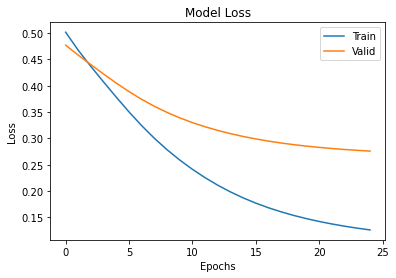

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

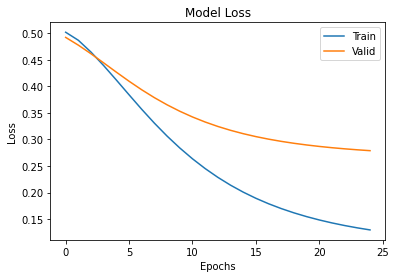

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

## **Predictions**

In [ ]:
pred1_1=model1.predict(X_test)
pred1_2=model2.predict(X_test)

pred_1=model1.predict(X_train)
pred_2=model2.predict(X_train)

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+str(i)]
    pred1_1[:,:,index]=scaler.inverse_transform(pred1_1[:,:,index])
    pred_1[:,:,index]=scaler.inverse_transform(pred_1[:,:,index])
    
    pred1_2[:,:,index]=scaler.inverse_transform(pred1_2[:,:,index])
    pred_2[:,:,index]=scaler.inverse_transform(pred_2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

## *Compare the actual and the predicted value and calculate the MAE*

In [ ]:
from sklearn.metrics import mean_absolute_error
 
for index,i in enumerate(train_df.columns):
  print(i)
  for j in range(1,2):
    print("Day ",j,":")
    print("value : ", y_test[:,j-1,index]," prediction M1 : ", pred1_1[:,j-1,index] ,"prediction : ",pred1_2[:,j-1,index])
    print("MAE-1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_1[:,j-1,index]),end=", ")
    print("MAE-2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_2[:,j-1,index]))
  print()
  print()
  

Streaming output truncated to the last 5000 lines.
value :  [0.]  prediction M1 :  [0.30530804] prediction :  [0.09960076]
MAE-1 :  0.3053080439567566, MAE-2 :  0.09960076212882996


Severe
consolidation in the left lung
Day  1 :
value :  [0.]  prediction M1 :  [0.40310442] prediction :  [0.23482087]
MAE-1 :  0.40310442447662354, MAE-2 :  0.2348208725452423


her intra-aortic balloon
pump
Day  1 :
value :  [0.]  prediction M1 :  [0.23729706] prediction :  [0.00583264]
MAE-1 :  0.23729705810546875, MAE-2 :  0.005832642316818237


paravalvular leak
Day  1 :
value :  [0.]  prediction M1 :  [0.8645785] prediction :  [0.6994262]
MAE-1 :  0.8645784854888916, MAE-2 :  0.6994261741638184


Hypothyroidism
Day  1 :
value :  [0.]  prediction M1 :  [0.05301169] prediction :  [0.26362115]
MAE-1 :  0.053011685609817505, MAE-2 :  0.26362115144729614


Clopidogrel
Day  1 :
value :  [1.]  prediction M1 :  [0.18821481] prediction :  [0.47157964]
MAE-1 :  0.8117851912975311, MAE-2 :  0.5284203588962555



In [ ]:
predictions = pd.DataFrame(columns=train_df.columns)

In [ ]:
predictions

,Ceftriaxone,diabetic,Known Allergies,Erythromycin Base,Codeine,rheumatoid disorder,neck pain,Pneumonia,coronary artery disease,Drugs,Penicillins,Compazine,rheumatoid arthritis,tingling,syndrome,hypertension,Difficulty breathing,Ischemic left foot,Nausea,hypercholesterolemia,GI bleed,CLL to large B cell NHL,substernal chest pain,aortic stenosis,difficulty swallowing,anterior tibial artery vein\r\r\n graft,vomiting,polyarthritis,Intubation,Esophogealduodenoscopy,pain across the\r\r\nupper back,PNA,The pain,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,Arteriogram of the left lower extremity,hepatitis B,muscle weakness,EGD,any loss of consciousness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol


In [ ]:
final = list()
for index,i in enumerate(train_df.columns):
  if pred1_1[:,0,index] >= 0.5:
    final.append(1)
  else :
    final.append(0)

predictions.loc[0] = final

In [ ]:
predictions

,Ceftriaxone,diabetic,Known Allergies,Erythromycin Base,Codeine,rheumatoid disorder,neck pain,Pneumonia,coronary artery disease,Drugs,Penicillins,Compazine,rheumatoid arthritis,tingling,syndrome,hypertension,Difficulty breathing,Ischemic left foot,Nausea,hypercholesterolemia,GI bleed,CLL to large B cell NHL,substernal chest pain,aortic stenosis,difficulty swallowing,anterior tibial artery vein\r\r\n graft,vomiting,polyarthritis,Intubation,Esophogealduodenoscopy,pain across the\r\r\nupper back,PNA,The pain,"Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement",tracheal intubation\r\r\nchest tube placement\r\r\ncentral line placement,Arteriogram of the left lower extremity,hepatitis B,muscle weakness,EGD,any loss of consciousness,...,neurosurgery,intervention,Home antihypertensive,sepsis,home HCTZ,repeat\r\r\nvideo swallow,self caths,Albuterol,SOB,wheeze,HCTZ,Terazosin,Tiotropium,albuterol sulfate,shortness,hydrochlorothiazide,lisinopril,terazosin,tiotropium bromide,omeprazole,clindamycin HCl,acetaminophen,Robitussin Chest Congestion,Retropharyngeal space infection,Pneumonia/pleural effusion,Urinary tract infection,Atrial fibrillation\r\r\nC-spine fx,assistance,swelling,an infection,the infection,CAT scan of your neck,a pneumonia,some fluid in your lung,an antibiotic,a urinary tract infection,an\r\r\nantibiotic,an old\r\r\nsmall fracture in your neck,START Clindamycin,Tylenol
0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##  *The List of the predictions*

In [ ]:
predicted_result1 = list()
for index,i in enumerate(train_df.columns):
  if pred1_1[:,0,index] >= 0.5:
    predicted_result1.append(str(i))
predicted_result1

['Known Allergies',
 'coronary artery disease',
 'Drugs',
 'aortic stenosis',
 'Coronary artery bypass grafts (LIMA-OM,RIMA-RCA), Aortic\r\r\nvalve replacement',
 'Thrombectomy of left lower extremity common femoral\r\r\nartery to peroneal artery bypass vein graft',
 'serial arteriogram\r\r\nof the left lower extremity',
 'surgery',
 'CAD',
 'balloon angioplasty of the left\r\r\nfemoral artery',
 'peroneal artery bypass graft',
 'balloon\r\r\nangioplasty of the distal anastamosis',
 'elective\r\r\nresection',
 'Right CFA aneurysm',
 'radiation proctitis',
 'revision of R CFA',
 'CABG',
 'peroneal bypass graft',
 'GIB',
 'Heparin gtt',
 'colonoscopy',
 'small polyps',
 'gastroesophageal reflux disease\r\r\nhypertension\r\r\nhyperlipidemia',
 'prostate disease',
 'increased PSA',
 'An echo',
 'coronary artery stenting',
 'heparin gtt',
 'critical aortic stenosis',
 'colon CA',
 'catheterization',
 'sudden cardiac death',
 '3VD',
 'respiratory distress',
 'NAD',
 'another GIB',
 'a flexib